In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import Dataset, DataLoader
import spacy
import os
import random
from collections import Counter
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [7]:
# !pip install torch


# ============================================================================
# 1. CHUẨN BỊ DỮ LIỆU
# ============================================================================

In [80]:
class Vocabulary:
    """Xây dựng từ điển cho một ngôn ngữ"""
    def __init__(self, max_vocab_size=10000):
        self.max_vocab_size = max_vocab_size
        self.word2idx = {}
        self.idx2word = {}
        self.word_freq = Counter()

        # Token đặc biệt
        self.PAD_TOKEN = '<pad>'
        self.UNK_TOKEN = '<unk>'
        self.SOS_TOKEN = '<sos>'
        self.EOS_TOKEN = '<eos>'

        self.pad_idx = 0
        self.unk_idx = 1
        self.sos_idx = 2
        self.eos_idx = 3

    def build_vocab(self, sentences):
        """Xây dựng từ điển từ danh sách câu"""
        # Đếm tần suất từ
        for sentence in sentences:
            self.word_freq.update(sentence)

        # Lấy top từ phổ biến
        most_common = self.word_freq.most_common(self.max_vocab_size - 4)

        # Thêm token đặc biệt
        self.word2idx = {
            self.PAD_TOKEN: self.pad_idx,
            self.UNK_TOKEN: self.unk_idx,
            self.SOS_TOKEN: self.sos_idx,
            self.EOS_TOKEN: self.eos_idx
        }

        # Thêm các từ phổ biến
        for idx, (word, freq) in enumerate(most_common, start=4):
            self.word2idx[word] = idx

        # Tạo ánh xạ ngược
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode(self, sentence):
        """Chuyển câu thành list index"""
        return [self.word2idx.get(word, self.unk_idx) for word in sentence]

    def decode(self, indices):
        """Chuyển list index thành câu"""
        return [self.idx2word.get(idx, self.UNK_TOKEN) for idx in indices]

    def __len__(self):
        return len(self.word2idx)


class TranslationDataset(Dataset):
    """Dataset cho dịch máy"""
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        src = self.src_sentences[idx]
        tgt = self.tgt_sentences[idx]

        # Encode thành indices
        src_indices = self.src_vocab.encode(src) + [self.src_vocab.eos_idx]
        tgt_indices = [self.tgt_vocab.sos_idx] + self.tgt_vocab.encode(tgt) + [self.tgt_vocab.eos_idx]

        return torch.LongTensor(src_indices), torch.LongTensor(tgt_indices)


def collate_fn(batch):
    """Collate function để xử lý padding và sorting"""
    src_batch, tgt_batch = zip(*batch)

    # Sắp xếp theo độ dài giảm dần (bắt buộc cho pack_padded_sequence)
    src_lengths = torch.LongTensor([len(s) for s in src_batch])
    sorted_indices = src_lengths.argsort(descending=True)

    src_batch = [src_batch[i] for i in sorted_indices]
    tgt_batch = [tgt_batch[i] for i in sorted_indices]
    src_lengths = src_lengths[sorted_indices]

    # Padding
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_padded = pad_sequence(tgt_batch, batch_first=True, padding_value=0)

    return src_padded, src_lengths, tgt_padded

# ============================================================================
# 2. MÔ HÌNH ENCODER-DECODER
# ============================================================================

In [108]:
import torch
import torch.nn as nn
import random
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# ----------------------------
# 🔹 Attention Layer
# ----------------------------
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        # hidden: (batch, hidden_size)
        # encoder_outputs: (batch, src_len, hidden_size)
        src_len = encoder_outputs.shape[1]

        # Repeat hidden across all time steps
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)

        # Energy = tanh(W[h_t;h_s])
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # (batch, src_len, hidden_size)
        attention = self.v(energy).squeeze(2)  # (batch, src_len)

        # Optional: mask padding tokens
        if mask is not None:
            attention = attention.masked_fill(mask == 0, -1e10)

        # Softmax normalization
        attn_weights = torch.softmax(attention, dim=1)  # (batch, src_len)
        return attn_weights


# ----------------------------
# 🔹 Encoder
# ----------------------------
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_size, num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_lengths):
        embedded = self.dropout(self.embedding(src))
        packed = pack_padded_sequence(embedded, src_lengths.cpu(), batch_first=True, enforce_sorted=True)
        packed_output, (hidden, cell) = self.lstm(packed)
        encoder_outputs, _ = pad_packed_sequence(packed_output, batch_first=True)
        return encoder_outputs, hidden, cell


# ----------------------------
# 🔹 Decoder (with Attention)
# ----------------------------
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.attention = Attention(hidden_size)
        self.lstm = nn.LSTM(
            hidden_size + embedding_dim, hidden_size, num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0
        )
        self.fc_out = nn.Linear(hidden_size * 2, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden, cell, encoder_outputs, mask=None):
        input_token = input_token.unsqueeze(1)  # (batch, 1)
        embedded = self.dropout(self.embedding(input_token))  # (batch, 1, emb_dim)

        # Attention
        attn_weights = self.attention(hidden[-1], encoder_outputs, mask).unsqueeze(1)  # (batch, 1, src_len)
        context = torch.bmm(attn_weights, encoder_outputs)  # (batch, 1, hidden_size)

        # LSTM input = [embedded, context]
        rnn_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))

        # Predict next token
        prediction = self.fc_out(torch.cat((output.squeeze(1), context.squeeze(1)), dim=1))
        return prediction, hidden, cell, attn_weights.squeeze(1)


# ----------------------------
# 🔹 Seq2Seq Model
# ----------------------------
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_lengths, tgt, teacher_forcing_ratio=1.0):
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.vocab_size

        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        mask = (src != 0).to(self.device)

        # Encode
        encoder_outputs, hidden, cell = self.encoder(src, src_lengths)

        # First decoder input is <sos>
        decoder_input = tgt[:, 0]

        # Dynamic teacher forcing decay (progressively reduce)
        tf_ratio = max(0.3, teacher_forcing_ratio * (0.98 ** random.randint(1, 5)))

        for t in range(1, tgt_len):
            prediction, hidden, cell, _ = self.decoder(decoder_input, hidden, cell, encoder_outputs, mask)
            outputs[:, t] = prediction

            teacher_force = random.random() < tf_ratio
            top1 = prediction.argmax(1)
            decoder_input = tgt[:, t] if teacher_force else top1

        return outputs
    

# ============================================================================
# 3. HUẤN LUYỆN
# ============================================================================


In [109]:
def train_epoch(model, dataloader, optimizer, criterion, clip, device):
    model.train()
    epoch_loss = 0

    for src, src_lengths, tgt in dataloader:
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()

        output = model(src, src_lengths, tgt, teacher_forcing_ratio=1.0)  # start full forcing
        output = output[:, 1:, :].reshape(-1, output.shape[-1])
        tgt = tgt[:, 1:].reshape(-1)

        loss = criterion(output, tgt)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, src_lengths, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, src_lengths, tgt, teacher_forcing_ratio=0)
            output = output[:, 1:, :].reshape(-1, output.shape[-1])
            tgt = tgt[:, 1:].reshape(-1)
            loss = criterion(output, tgt)
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)


# ============================================================================
# 4. DỰ ĐOÁN (INFERENCE)
# ============================================================================


In [110]:
def translate_sentence(model, sentence, src_vocab, tgt_vocab, src_tokenizer, device, max_len=50):
    """
    Dịch một câu từ tiếng Anh sang tiếng Pháp

    Args:
        model: mô hình đã train
        sentence: câu tiếng Anh (string)
        src_vocab, tgt_vocab: từ điển
        src_tokenizer: tokenizer cho tiếng Anh
        device: cuda/cpu
        max_len: độ dài tối đa câu dịch

    Returns:
        translated_sentence: câu tiếng Pháp (string)
    """
    model.eval()

    # Tokenize
    tokens = src_tokenizer(sentence.lower())
    tokens = [token.text for token in tokens]

    # Encode
    indices = src_vocab.encode(tokens) + [src_vocab.eos_idx]
    src_tensor = torch.LongTensor(indices).unsqueeze(0).to(device)  # (1, src_len)
    src_lengths = torch.LongTensor([len(indices)])

    with torch.no_grad():
        # Encoder
        hidden, cell = model.encoder(src_tensor, src_lengths)

        # Decoder
        decoder_input = torch.LongTensor([tgt_vocab.sos_idx]).unsqueeze(0).to(device)
        translated_indices = []

        for _ in range(max_len):
            prediction, hidden, cell = model.decoder(decoder_input, hidden, cell)
            predicted_token = prediction.argmax(1).item()

            if predicted_token == tgt_vocab.eos_idx:
                break

            translated_indices.append(predicted_token)
            decoder_input = torch.LongTensor([predicted_token]).unsqueeze(0).to(device)

    # Decode
    translated_tokens = tgt_vocab.decode(translated_indices)
    translated_sentence = ' '.join(translated_tokens)

    return translated_sentence


def calculate_bleu(model, test_data, src_vocab, tgt_vocab, src_tokenizer, device):
    """Tính BLEU score trên tập test"""
    bleu_scores = []
    smoothing = SmoothingFunction().method1

    for src_sent, tgt_sent in test_data:
        src_text = ' '.join(src_sent)
        translated = translate_sentence(model, src_text, src_vocab, tgt_vocab, src_tokenizer, device)

        reference = [tgt_sent]
        candidate = translated.split()

        score = sentence_bleu(reference, candidate, smoothing_function=smoothing)
        bleu_scores.append(score)

    return np.mean(bleu_scores)


# ============================================================================
# 5. MAIN - SỬ DỤNG
# ============================================================================

In [ ]:
# Removed the main() function definition and moved the code outside
# This makes the variables (model, vocabularies, tokenizer, device, etc.) available globally.

# Cấu hình
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
EMBEDDING_DIM = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 2
DROPOUT = 0.5
LEARNING_RATE = 0.001
BATCH_SIZE = 64
NUM_EPOCHS = 10
CLIP = 1

# -- Đường dẫn tới thư mục dữ liệu (tương đối với notebook) --
data_dir = '/content/'

def load_lines(path):
    """Đọc file và trả về danh sách dòng (không tokenized)"""
    lines = []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = line.strip()
            if line:
                lines.append(line)
    return lines


def tokenize_lines(lines, tokenizer):
    """Tokenize danh sách câu trả về list of token lists"""
    tokenized = []
    for line in lines:
        toks = [t.text for t in tokenizer(line.lower()) if t.text.strip()]
        tokenized.append(toks)
    return tokenized

# Tập tin theo cấu trúc workspace: dataset/<split>/(file)
train_en_path = os.path.join(data_dir, 'train.en')
train_fr_path = os.path.join(data_dir, 'train.fr')
val_en_path = os.path.join(data_dir, 'val.en')
val_fr_path = os.path.join(data_dir, 'val.fr')
test_en_path = os.path.join(data_dir, 'test_2018_flickr.en')
test_fr_path = os.path.join(data_dir, 'test_2018_flickr.fr')


# Load raw lines
train_en_lines = load_lines(train_en_path)
train_fr_lines = load_lines(train_fr_path)
val_en_lines = load_lines(val_en_path)
val_fr_lines = load_lines(val_fr_path)
test_en_lines = load_lines(test_en_path)
test_fr_lines = load_lines(test_fr_path)

# Tokenizers: thử load spacy models, fallback sang spacy.blank nếu model chưa cài
try:
    en_tokenizer = spacy.load('en_core_web_sm')
except Exception:
    # Nếu model en_core_web_sm chưa cài, dùng blank tokenizer (đơn giản)
    print("Warning: en_core_web_sm not found. Using spacy.blank('en'). Please install with !python -m spacy download en_core_web_sm")
    en_tokenizer = spacy.blank('en')

try:
    fr_tokenizer = spacy.load('fr_core_news_sm')
except Exception:
    print("Warning: fr_core_news_sm not found. Using spacy.blank('fr'). Please install with !python -m spacy download fr_core_news_sm")
    fr_tokenizer = spacy.blank('fr')


# Tokenize tất cả
print('Tokenizing...')
train_en_tok = tokenize_lines(train_en_lines, en_tokenizer)
train_fr_tok = tokenize_lines(train_fr_lines, fr_tokenizer)
val_en_tok = tokenize_lines(val_en_lines, en_tokenizer)
val_fr_tok = tokenize_lines(val_fr_lines, fr_tokenizer)
test_en_tok = tokenize_lines(test_en_lines, en_tokenizer)
test_fr_tok = tokenize_lines(test_fr_lines, fr_tokenizer)

# Build vocabularies (từ train set)
print('Building vocabularies...')
src_vocab = Vocabulary(max_vocab_size=10000)
src_vocab.build_vocab(train_en_tok)
tgt_vocab = Vocabulary(max_vocab_size=10000)
tgt_vocab.build_vocab(train_fr_tok)

# Tạo Dataset và DataLoader
train_dataset = TranslationDataset(train_en_tok, train_fr_tok, src_vocab, tgt_vocab)
val_dataset = TranslationDataset(val_en_tok, val_fr_tok, src_vocab, tgt_vocab)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# test_data dùng cho calculate_bleu (dạng list of (src_tokens, tgt_tokens))
test_data = list(zip(test_en_tok, test_fr_tok))

# Sanity prints
print(f'Train examples: {len(train_dataset)}')
print(f'Val examples: {len(val_dataset)}')
print(f'Test examples: {len(test_data)}')
print('Example tokenized (src -> tgt):')
print(train_en_tok[0][:20])
print(train_fr_tok[0][:20])

# Khởi tạo mô hình (dùng kích thước từ vocab đã tạo)
encoder = Encoder(len(src_vocab), EMBEDDING_DIM, HIDDEN_SIZE, NUM_LAYERS, DROPOUT)
decoder = Decoder(len(tgt_vocab), EMBEDDING_DIM, HIDDEN_SIZE, NUM_LAYERS, DROPOUT)
model = Seq2Seq(encoder, decoder, device).to(device)

# Optimizer và loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Use ignore_index for PAD_TOKEN in CrossEntropyLoss
criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab.pad_idx)


# (Phần training vẫn như cũ)
best_val_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, CLIP, device)
    val_loss = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    print(f'Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping!")
            break

bleu_score = calculate_bleu(model, test_data, src_vocab, tgt_vocab, en_tokenizer, device)
print(f'BLEU Score: {bleu_score:.4f}')


Tokenizing...
Building vocabularies...
Train examples: 29000
Val examples: 1014
Test examples: 1071
Example tokenized (src -> tgt):
['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
['deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '.']
Epoch 1/10
Train Loss: 4.904 | Val Loss: 4.645
Epoch 2/10
Train Loss: 3.993 | Val Loss: 4.313
Epoch 3/10
Train Loss: 3.600 | Val Loss: 4.093
Epoch 4/10
Train Loss: 3.306 | Val Loss: 3.964
Epoch 5/10
Train Loss: 3.075 | Val Loss: 3.866
Epoch 6/10
Train Loss: 2.893 | Val Loss: 3.752
Epoch 7/10
Train Loss: 2.724 | Val Loss: 3.695
Epoch 8/10
Train Loss: 2.610 | Val Loss: 3.681
Epoch 9/10
Train Loss: 2.462 | Val Loss: 3.688
Epoch 10/10
Train Loss: 2.362 | Val Loss: 3.593
BLEU Score: 0.1221


In [84]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import spacy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [85]:
# Hyperparameters
EMBEDDING_DIM = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 2
DROPOUT = 0.5
LEARNING_RATE = 0.001
BATCH_SIZE = 64
NUM_EPOCHS = 10
CLIP = 1


In [51]:
import os

# ⚙️ Base folder chứa các subfolder train.en/, train.fr/, ...
data_dir = os.path.join(os.getcwd(), "dataset")

# 👉 Đường dẫn chính xác tới từng file thật (vì mỗi file nằm trong folder cùng tên)
train_en_path = os.path.join(data_dir, "train.en", "train.en")
train_fr_path = os.path.join(data_dir, "train.fr", "train.fr")
val_en_path = os.path.join(data_dir, "val.en", "val.en")
val_fr_path = os.path.join(data_dir, "val.fr", "val.fr")
test_en_path = os.path.join(data_dir, "test_2018_flickr.en", "test_2018_flickr.en")
test_fr_path = os.path.join(data_dir, "test_2018_flickr.fr", "test_2018_flickr.fr")

# ✅ Kiểm tra nhanh
for path in [train_en_path, train_fr_path, val_en_path, val_fr_path, test_en_path, test_fr_path]:
    print("✔", os.path.exists(path), "-", path)


✔ True - d:\HK7NAM4\LTSM\English_French_Machine_Translation_LSTM\dataset\train.en\train.en
✔ True - d:\HK7NAM4\LTSM\English_French_Machine_Translation_LSTM\dataset\train.fr\train.fr
✔ True - d:\HK7NAM4\LTSM\English_French_Machine_Translation_LSTM\dataset\val.en\val.en
✔ True - d:\HK7NAM4\LTSM\English_French_Machine_Translation_LSTM\dataset\val.fr\val.fr
✔ True - d:\HK7NAM4\LTSM\English_French_Machine_Translation_LSTM\dataset\test_2018_flickr.en\test_2018_flickr.en
✔ True - d:\HK7NAM4\LTSM\English_French_Machine_Translation_LSTM\dataset\test_2018_flickr.fr\test_2018_flickr.fr


In [49]:
import glob
print("🧾 Checking dataset files in:", data_dir)
for f in glob.glob(os.path.join(data_dir, "*.*")):
    print(" -", os.path.basename(f))


🧾 Checking dataset files in: d:\HK7NAM4\LTSM\English_French_Machine_Translation_LSTM\dataset
 - test_2018_flickr.en
 - test_2018_flickr.fr
 - train.en
 - train.fr
 - val.en
 - val.fr


In [86]:
def load_lines(path):
    """Đọc file và trả về danh sách dòng (không tokenized)."""
    lines = []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            line = line.strip()
            if line:
                lines.append(line)
    return lines


def tokenize_lines(lines, tokenizer):
    """Tokenize danh sách câu trả về list of token lists."""
    tokenized = []
    for line in lines:
        toks = [t.text for t in tokenizer(line.lower()) if t.text.strip()]
        tokenized.append(toks)
    return tokenized


In [87]:
train_en_path = os.path.join(data_dir, "train.en", "train.en")
train_fr_path = os.path.join(data_dir, "train.fr", "train.fr")
val_en_path = os.path.join(data_dir, "val.en", "val.en")
val_fr_path = os.path.join(data_dir, "val.fr", "val.fr")
test_en_path = os.path.join(data_dir, "test_2018_flickr.en", "test_2018_flickr.en")
test_fr_path = os.path.join(data_dir, "test_2018_flickr.fr", "test_2018_flickr.fr")

train_en_lines = load_lines(train_en_path)
train_fr_lines = load_lines(train_fr_path)
val_en_lines = load_lines(val_en_path)
val_fr_lines = load_lines(val_fr_path)
test_en_lines = load_lines(test_en_path)
test_fr_lines = load_lines(test_fr_path)

print(f"✅ Loaded datasets | Train: {len(train_en_lines)} | Val: {len(val_en_lines)} | Test: {len(test_en_lines)}")


✅ Loaded datasets | Train: 29000 | Val: 1014 | Test: 1071


In [88]:
try:
    en_tokenizer = spacy.load('en_core_web_sm')
except Exception:
    print("⚠️ en_core_web_sm not found → using spacy.blank('en')")
    en_tokenizer = spacy.blank('en')

try:
    fr_tokenizer = spacy.load('fr_core_news_sm')
except Exception:
    print("⚠️ fr_core_news_sm not found → using spacy.blank('fr')")
    fr_tokenizer = spacy.blank('fr')

print("✅ Tokenizers loaded successfully!")


⚠️ en_core_web_sm not found → using spacy.blank('en')
⚠️ fr_core_news_sm not found → using spacy.blank('fr')
✅ Tokenizers loaded successfully!
✅ Tokenizers loaded successfully!


In [89]:
print("🔠 Tokenizing data...")

train_en_tok = tokenize_lines(train_en_lines, en_tokenizer)
train_fr_tok = tokenize_lines(train_fr_lines, fr_tokenizer)
val_en_tok = tokenize_lines(val_en_lines, en_tokenizer)
val_fr_tok = tokenize_lines(val_fr_lines, fr_tokenizer)
test_en_tok = tokenize_lines(test_en_lines, en_tokenizer)
test_fr_tok = tokenize_lines(test_fr_lines, fr_tokenizer)

print(f"✅ Tokenized {len(train_en_tok)} training examples.")


🔠 Tokenizing data...
✅ Tokenized 29000 training examples.
✅ Tokenized 29000 training examples.


In [90]:
print("🧱 Building vocabularies...")
src_vocab = Vocabulary(max_vocab_size=10000)
src_vocab.build_vocab(train_en_tok)
tgt_vocab = Vocabulary(max_vocab_size=10000)
tgt_vocab.build_vocab(train_fr_tok)

train_dataset = TranslationDataset(train_en_tok, train_fr_tok, src_vocab, tgt_vocab)
val_dataset = TranslationDataset(val_en_tok, val_fr_tok, src_vocab, tgt_vocab)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

test_data = list(zip(test_en_tok, test_fr_tok))

print(f"Train examples: {len(train_dataset)} | Val examples: {len(val_dataset)} | Test examples: {len(test_data)}")
print("🔍 Example:", train_en_tok[0][:10], "→", train_fr_tok[0][:10])


🧱 Building vocabularies...
Train examples: 29000 | Val examples: 1014 | Test examples: 1071
🔍 Example: ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes'] → ['deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '.']


In [91]:
encoder = Encoder(len(src_vocab), EMBEDDING_DIM, HIDDEN_SIZE, NUM_LAYERS, DROPOUT)
decoder = Decoder(len(tgt_vocab), EMBEDDING_DIM, HIDDEN_SIZE, NUM_LAYERS, DROPOUT)
model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab.pad_idx)

print("✅ Model initialized successfully!")


✅ Model initialized successfully!


In [ ]:
from tqdm import tqdm

# (Phần training vẫn như cũ, chỉ thêm progress bar)
best_val_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0

    # progress bar cho train_loader
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]", leave=False)

    for batch in progress:
        # giữ nguyên cách train_epoch cũ
        loss = train_epoch(model, [batch], optimizer, criterion, CLIP, device)
        epoch_loss += loss
        progress.set_postfix(loss=loss)

    train_loss = epoch_loss / len(train_loader)
    val_loss = evaluate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    print(f'Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping!")
            break

bleu_score = calculate_bleu(model, test_data, src_vocab, tgt_vocab, en_tokenizer, device)
print(f'BLEU Score: {bleu_score:.4f}')


Epoch 1/10
Train Loss: 4.855 | Val Loss: 4.634


Epoch 2/10
Train Loss: 3.967 | Val Loss: 4.383


Epoch 3/10
Train Loss: 3.565 | Val Loss: 4.068


Epoch 4/10
Train Loss: 3.266 | Val Loss: 3.934


Epoch 5/10
Train Loss: 3.055 | Val Loss: 3.765


Epoch 6/10
Train Loss: 2.876 | Val Loss: 3.786


Epoch 7/10
Train Loss: 2.704 | Val Loss: 3.717


Epoch 8/10
Train Loss: 2.582 | Val Loss: 3.702


Epoch 9/10
Train Loss: 2.455 | Val Loss: 3.591


Epoch 10/10
Train Loss: 2.356 | Val Loss: 3.551
BLEU Score: 0.1255
BLEU Score: 0.1255


In [96]:
# 🔹 Load lại model đã train sẵn
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.to(device)
model.eval()

print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [104]:
import json

# 🔹 Tạo log thủ công từ kết quả bạn có
log = {
    "train_loss": [4.855, 3.967, 3.565, 3.266, 3.055, 2.876, 2.704, 2.582, 2.455, 2.356],
    "val_loss":   [4.634, 4.383, 4.068, 3.934, 3.765, 3.786, 3.717, 3.702, 3.591, 3.551]
}

# 🔹 Lưu lại để mai mốt vẽ biểu đồ không cần nhập lại
with open("train_log.json", "w") as f:
    json.dump(log, f)

print("✅ train_log.json đã được tạo thành công!")


✅ train_log.json đã được tạo thành công!


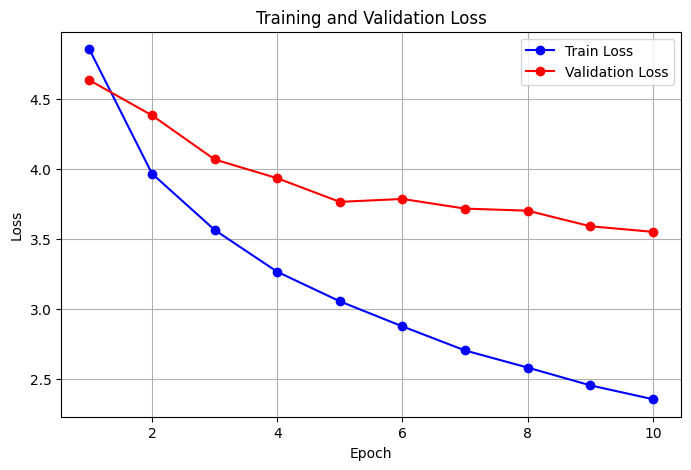

In [105]:
import matplotlib.pyplot as plt
import json

# 🔹 Đọc log
with open('train_log.json', 'r') as f:
    log = json.load(f)

train_losses = log["train_loss"]
val_losses = log["val_loss"]
epochs = range(1, len(train_losses) + 1)

# 🔹 Vẽ
plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [123]:
sentence = "A beautiful girl is riding a bike with a child."
translation = translate_sentence(model, sentence, src_vocab, tgt_vocab, en_tokenizer, device)
print(f'English: {sentence}')
print(f'French: {translation}')

English: A beautiful girl is riding a bike with a child.
French: une petite fille fait du vélo avec un enfant .
